Using Zhang's algorithm for Camera Calibration, submitted by Kumaraguru Sivasankaran for ECE 661:Hw8

#### STAGE 1: Pre-processing

1. We start with pre-processing the image dataset in order to obtain the corner coordinates from the images of the calibration sheet. A suitable resizing is applied if the image size is too large. For this task, large image size was not of any additional help but increases the computational burden. The input image is converted into grayscale and then, subsequently into binary image format with appropriate threshold value. Finally, a edge detection algorithm like Canny edge detector is applied to get the edges in the image. 

2. Given this edge image, we apply Hough transform to look for lines in the image. By keeping a threshold of 50 continuous pixels to constitute a line, we can obtain the distance $\rho$ and angle $\theta$ of all lines in the given image. Note, at this point, we have detected all possible lines in the image and this may be more than what we require for finding corners. Also, there will be high chances of duplicate lines occuring at pixel level distances away and cause false detections. 

3. In order to narrow down our selection to correct pair of lines that make a corner in image, the identified lines in above step are sorted into horizontal and vertical lines based on angles. We apply a non-maximal suppression type algorithm for removing the lines that are closer to each other (what we describe as duplicates). It was found experimentally that a pixel distance of less than 8 between two lines can be used to find the presence of duplicates. Please note that the hough transform works on voting scheme that returns the lines in order of highest votes it received. Thus, keeping the order of lines returned, the top ten unique horizontal lines and eight unique vertical lines are retained while discarding the rest. ie. if two lines are found similar, the line appearing first in the order as returned from hough transform will be retained. This was useful to identify high quality lines. We also checked the existence of a line before adding to the final list of unique horizontal and vertical lines.

4. The obtained unique horizontal and vertical lines are now sorted as per the absolute value of $\rho$. This would be useful later to keep order of corner points identified and help to appropriately label in same order across all images. 

5. The intersection of unique horizontal and vertical lines gives the corner points of interest to us. We use a corner label function to mark the identified point and label it with a numerical number. A naming convention of numbers running from left to right and top to bottom is followed across all images effortlessly due to step 4. The lines are also marked for reference. Thus, the corner points are found in a given image. Now, repeat the steps 1-5 for obtaining corner points for all images in the dataset. A minimum of 20 successful images are required for better quality of camera calibration. 

6. The world coordinates are obtained from measuring the calibration sheet physically with a ruler. Although it was found that the calibration sheet gave non-standard values for distances (24.5 mm), a rounding off to nearest value of 25mm proved useful.

Please note that at each stage, if the image gave inconsistent outputs, the image was not processed further and discarded. Say for example, the hough transform detected less number of lines, or less number of horizontal lines were identified after sorting etc. are discarded. Only those images that gave perfect unique horizontal and vertical lines were retained for stage 2. This is partly due to different hyperparameters set in grayscale, binary, edge detection, hough transform etc. Having a single set of hyperparameters for processing all images is not practically possible given the differences in image quality. We made sure there are atleast 20+ successful images processed for stage 2.

#### STAGE 2: Zhang's algorithm

1. Establish correspondences between extracted corners (image coordinates) and their world coordinates. Here, world coordinates are manually obtained from the calibration sheet. To find the homography, I have used both linear least squares algorithm and LM based non-linear least squares algorithm and found either one is good enough.

2. Using the homographies obtained, we can apply the Zhang's calibration algorithm. We end up getting the intrinsic and extrinsic parameters as described below:

Details: Zhang's algorithm is based on the fact that the camera image of the absolute conic $\omega_{\infty}$ is independent of R and t and it is related with it's image by $\omega=K^{-T}K^{-1}$. Also, we know from the fact that any plane in the world frame (such as z=0 plane) samples $\omega_{\infty}$ at exactly two points. The images of these two points fall on the conic $\omega$ in the camera image plane such that they should obey the conic $\vec{x}^T\omega \vec{x} = 0$. By plugging in the coordinates of the two image points in the conic constraint equations, we get the following equations:

$$\vec{h_1}\omega \vec{h_1} = \vec{h_2}\omega \vec{h_2}$$
$$\vec{h_1}\omega \vec{h_2} = 0$$

Since, $\omega = 
\begin{bmatrix} 
\omega_{11}  &\omega_{12}  &\omega_{13} \\
\omega_{21}  &\omega_{22}  &\omega_{23} \\
\omega_{31}  &\omega_{32}  &\omega_{33} \\
\end{bmatrix}$ is symmetric and in it's homogeneous representation requires only 6 unknowns, we can stack them as 
$$b =\begin{bmatrix} 
\omega_{11}  \\
\omega_{12}  \\
\omega_{22}  \\
\omega_{13}  \\
\omega_{23}  \\
\omega_{33}  \\
\end{bmatrix}$$

For ease of representation, we can convert the above two equations in the format $$\vec{v}^T_{12}\vec{b}=0$$  $$(\vec{v_{11}}-\vec{v_{22}})^T\vec{b}=0$$ where 
$\begin{bmatrix}
h_{i1}h_{j1}\\
h_{i1}h_{j2}+ h_{i2}h_{j1}\\
h_{i2}h_{j2}\\
h_{i3}h_{j1}+ h_{i1}h_{j3}\\
h_{i3}h_{j2}+ h_{i2}h_{j3}\\
h_{i3}h_{j3}\\
\end{bmatrix}$.
We can stack them up into one matrix $V\vec{b}=0$ with $V = \begin{bmatrix} \vec{v}^T_{12}\\ (\vec{v_{11}}-\vec{v_{22}})^T\end{bmatrix}$. So far, we did this using homography obtained from one image pair. We can do for large number of such images and stack them as big V matrix such that $\begin{bmatrix} 
V_{1}  \\
V_{2}  \\
V_{3}  \\
\vdots \\
V{n}  \\
\end{bmatrix}b = 0$.
Once we solve for b using any of the methods studied in the course (Linear least squares / using SVD decomposition), we can get $\omega$. Using this results, we need to recover the extrinsic parameter K.

Recall 
$K = \begin{bmatrix}
\alpha_x &s &x_0\\
0 &\alpha_y &y_0\\
0 & 0& 1
\end{bmatrix}$. Using the trick invented by Zhang by introducing the new variable $\lambda$, we can recover the K matrix as follows:
$$x_0 = \frac{\omega_{12}\omega_{13}- \omega_{11}\omega_{23}}{\omega_{11}\omega_{22} - \omega_{12}^2}$$
$$\lambda = \omega_{33} - \frac{\omega_{13}^2+x_0(\omega_{12}\omega_{13}- \omega_{11}\omega_{23})}{\omega_{11}}$$
$$\alpha_x = \sqrt{\frac{\lambda}{\omega_{11}}}$$
$$\alpha_y = \sqrt{\frac{\lambda\omega_{11}}{\omega_{11}\omega_{22}-\omega_{12}^2}}$$
$$s = \frac{\omega_{12}\alpha_{x}^2\alpha_y}{\lambda}$$
$$y_0 = \frac{sx_0}{\alpha_y}-\frac{\omega_{13}\alpha_x^2}{\lambda}$$


We can now use the intrinsic parameter K to find the extrinsic parameters R and t for a given homography H. Using the relationship, $K^{-1}[\vec{h_1}, \vec{h_2}, \vec{h_3}] = [\vec{r_1}, \vec{r_2}, \vec{t}]$, we can recover the rotation matrix 
$[\vec{r_1}, \vec{r_2}, \vec{r_3}] = [nK^{-1}\vec{h_1}, nK^{-1}\vec{h_1}, \vec{r_1}x\vec{r_2}]$ where normalizing constant $n =\frac{1}{||K^{-1}\vec{h_1}||}$ and $\vec{t} = nK^{-1}\vec{h_3}$.

3. From the camera matrix obtained, we can reproject the world points into image coordinates and check for consistency with the initial extracted image points.

4. The error between reprojected image coordinates and actual image coordinates can be measured from their Euclidean distance measure which is indicative of the accuracy of the implementation. 

#### STAGE 3: Refining the Camera calibration using Non-linear least squares optimization

1. Here, we appply non-linear least squares optimization using Levenberg-Marquardt for refining the parameters. In general, we are trying to minimize $d_{geom}^2 = ||\vec{X} - f(\vec{p})||$ where $\vec{p} = (K, R_i, t_i | i=1,2,3,..)^T$. To make sure we get a meaningful values for the rotation matrix R, we use the rodrigues 3-parameter representation $\vec{w} = [w_x, w_y, w_z]$ for R matrix such that $[\vec{w}]_X = \begin{bmatrix} 0 &-w_z &w_y \\w_z &0 &-w_x \\-w_y &w_x &0  \end{bmatrix}$. We can construct the R matrix for the given vector $\vec{w}$ using $$R = e^{[\vec{w}]_X} = I_{3*3} + \frac{sin \phi}{\phi} [\vec{w}]_X + \frac{1-cos(\phi)}{\phi}[\vec{w}]^2_X$$ where $\phi = ||\vec{w}||$

2. Since most of the camera has rotation distortion, we can also jointly optimize the radial distortion parameters by including the following correction to our predicted coordinates.
$$\hat{x}_{rad} = \hat{x} + (\hat{x}-x_0) [k_1 r^2 + k_2 r^4]$$
$$\hat{y}_{rad} = \hat{y} + (\hat{y}-y_0) [k_1 r^2 + k_2 r^4]$$

where $r^2 = (\hat{x}-x_0)^2+(\hat{y}-y_0)^2$ and $k_1, k_2$ are the distortion parameters that need to be optimized jointly.

3. The quality of refinement is demonstrated by comparing quantitatively the mean and variance of error before and after LM optimization.

In [24]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  7 11:20:26 2018

@author: Kumaraguru
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
import os

dataset = 1
if dataset==0:
    folder = r"C:\Users\Kumaraguru\OneDrive - purdue.edu\Graduate studies\ECE661\Homework 8\Files\Dataset1"
else:
    folder = r"C:\Users\Kumaraguru\OneDrive - purdue.edu\Graduate studies\ECE661\Homework 8\Files\OwnDataset"

def NMS(lines, string):
    """ a function to perform non-maximum suppression on lines returned from 
        hough transform
    """
    if len(lines)<10:
        print("Error: less no. of lines detected")
        Error = 1
        return lines, Error
    Error = 0
    rholist = abs(lines[:,0])
    indices = np.array([0,rholist[0]])
    index = np.array([0])
    for xiter in range(0, len(rholist)):
        if min(abs(rholist[xiter]-indices)) > 8:
            indices = np.append(indices, rholist[xiter])
            index = np.append(index, xiter)
    NMSlines = lines[index,:]
    if string =="horz" and len(NMSlines) < 8:
        print("Error: less horzlines in {}".format(filename))
        Error = 1
    if string =="vert" and len(NMSlines) < 10:
        print("Error: less vertlines in {}".format(filename))
        Error = 1
    return NMSlines, Error

def cornerPoints(Hlines1, Vlines2):
    """  For given pairs of horizontal and vertical lines, 
        this function will return the corner points indentified from the
        cross products
    """
    cPoints = []
    for yiter in range(0,10):
        for xiter in range(0,8):
            c = np.cross(Hlines1[xiter], Vlines2[yiter])
            c = c/c[2]
            cPoints.append(c)
    return  cPoints

def cornerLabel(image, cornerPoints, show, filename, color, textshow=0):
    """ Plots the points on given image. User can control color.
        The points are names 1 to len(points) and can be controlled by specifying 
        same
    """
    for xiter in range(0, len(cornerPoints)):
        X, Y, _ = cornerPoints[xiter]
        X, Y = int(X), int(Y)
        cv2.circle(image, (X,Y), 2, color, -1)
        if textshow ==1:
            #X, Y = X+2, Y+2
            cv2.putText(image, str(xiter+1),(X,Y),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0))
    if show==1:   
        cv2.imshow(str(filename)+"_corner", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()  
    return image

def extractLines(lines):
    """ To Extract homogeneous representation of lines 
        from the parametric form of lines specified as rho and theta
        by Hough transform
    """
    homo_lines = []
    for x in range(0, len(lines)):
        rho,theta = lines[x,0], lines[x,2]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        X = [x1, y1, 1]
        Y = [x2, y2, 1]
        homo_lines.append(np.cross(X,Y))
    return homo_lines

def checkConsistency(lines):
    """ Function to detect clustering of lines and reject the image 
        for further processing. This is done as final check.
    """
    Error = 0
    rholist = abs(lines[:,0])
    diff = []
    for xiter in range(1,len(rholist)):
        diff.append(abs(rholist[xiter]-rholist[xiter-1]))
    if min(diff) < 15:
        Error = 1
        print("Error: Lines are clustered: {}".format(min(diff)))
    return Error

def printLines(img, lines, filename):
    """ Helps to plot lines in the image
    """
    lines = lines[abs(lines[:,0]).argsort()]
    Error = checkConsistency(lines)
    for x in range(0, len(lines)):
        rho,theta = lines[x,0], lines[x,2]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),1)
    return lines, Error
            
def get_Homography(world, image):
    """ Finds homography between world and image using
        linear least squares algorithm
    """
    n = len(world)
    P = np.zeros((2*n,8), dtype=float)
    b = np.zeros((2*n,1), dtype=float)
    for xiter in range(len(world)):
        x , y = world[xiter][0], world[xiter][1]
        xd, yd = image[xiter][0], image[xiter][1]
        P[2*xiter] = [x, y, 1, 0, 0, 0, -x*xd, -y*xd]
        P[2*xiter+1] = [0, 0, 0, x, y, 1, -x*yd, -y*yd]
        b[2*xiter], b[2*xiter+1] = xd, yd
    H_temp,a,b,c = np.linalg.lstsq(P,b, rcond=None)
    H_temp = np.append(H_temp, 1)
    H = np.zeros((3,3), dtype=float)
    H[0,:] = H_temp[0:3]
    H[1,:] = H_temp[3:6]
    H[2,:] = H_temp[6:9]
    return H

def objfun_lm_H(h, P, b):
    """ objective function for LM optimization to refine homography
        optional - used to test working of scipy lm
    """
    return np.matmul(P,h) -b

def get_Homography_lm(world, image):
    """ Homography refinement using Levenberg margquardt
        optional
    """
    n = len(world)
    P = np.zeros((2*n,8), dtype=float)
    b = np.zeros((2*n,), dtype=float)
    for xiter in range(len(world)):
        x , y = world[xiter][0], world[xiter][1]
        xd, yd = image[xiter][0], image[xiter][1]
        P[2*xiter] = [x, y, 1, 0, 0, 0, -x*xd, -y*xd]
        P[2*xiter+1] = [0, 0, 0, x, y, 1, -x*yd, -y*yd]
        b[2*xiter], b[2*xiter+1] = xd, yd
    h0 = np.ones((8,))
    result = least_squares(objfun_lm_H, h0, args=(P, b), method='lm', verbose=0)
    H_temp = result.x
    H_temp = np.append(H_temp, 1)
    H = np.zeros((3,3), dtype=float)
    H[0,:] = H_temp[0:3]
    H[1,:] = H_temp[3:6]
    H[2,:] = H_temp[6:9]
    return H

def get_vstack(H):
    """ function to prepare for Zhang's algorithm
        stacks up the V matrix for given H
    """
    [[h11, h12, h13], [h21, h22, h23], [h31,h32,h33]] = np.transpose(H)
    vstack = np.zeros((2,6), dtype=float)
    v12 = np.array([h11*h21, h11*h22+h12*h21, h12*h22, h13*h21+h11*h23, h13*h22+h12*h23, h13*h23])
    v11 = np.array([h11*h11, h11*h12+h12*h11, h12*h12, h13*h11+h11*h13, h13*h12+h12*h13, h13*h13])
    v22 = np.array([h21*h21, h21*h22+h22*h21, h22*h22, h23*h21+h21*h23, h23*h22+h22*h23, h23*h23])
    vstack[0,:] = v12
    vstack[1,:] = v11 - v22
    return vstack

def solve_for_W_SingularValueDecomposition(nH):
    """ Performs SVD to solve for parameters of image of 
        absolute conic. Input is set of all homographies collected from dataset
    """
    sample_size = len(nH)
    V = np.zeros((2*sample_size, 6), dtype=float)
    for xiter in range(sample_size):
        V[xiter:xiter+2,:] = get_vstack(nH[xiter])
    U, S, D = np.linalg.svd(V)
    b = D[-1,:] # remember svd(A)=US(V^T)
    return b


def objfun_lm_W(parameters, wPoints, cPoints, radial_distortion=0):
    """ Objective function for LM optimization for refining K, Ri, ti
    """
    x_pred_list = []
    x_list = []
    y_pred_list = []
    y_list = []
    K = np.array([[parameters[0], parameters[1], parameters[2]],\
                  [0, parameters[3], parameters[4]],\
                  [0 , 0 , 1]])
    if radial_distortion ==0:
        count = 4
    else:
        k1 = parameters[5]
        k2 = parameters[6]
        count = 6
        K1 = np.array([[parameters[0], 0, parameters[2]],\
                  [0, parameters[3], parameters[4]],\
                  [0 , 0 , 1]])
    for success in range(0, len(cPoints)):
        c80 = cPoints[success]
        wx = parameters[count+1] 
        wy = parameters[count+2] 
        wz = parameters[count+3] 
        tx = parameters[count+4] 
        ty = parameters[count+5] 
        tz = parameters[count+6]
        count = count+6
        W = np.array([[0, -wz, wy],\
                      [wz, 0, -wx],\
                      [-wy, wx, 0]])
        phi = np.linalg.norm([wx,wy,wz])
        R = np.eye(3) + (np.sin(phi)/phi)*W + ((1-np.cos(phi))/phi**2)*W@W
        t =np.array([[tx],
                     [ty],
                     [tz]])
        Rt = np.concatenate((R,t), axis=1)
        for corner in range(0, len(wcPoints)):
            world = np.array([wPoints[corner][0], wPoints[corner][1], 0, 1]) 
            pred_x = K@Rt@world
            pred_x = pred_x/pred_x[2]
            if radial_distortion == 10:
                pred_x = np.linalg.inv(K1)@pred_x
                #pred_x = pred_x/pred_x[2]
                r = np.sqrt((pred_x[0])**2 + (pred_x[1])**2) 
                pred_x[0] = pred_x[0] + (pred_x[0])*(k1*r**2 + k2*r**4)
                pred_x[1] = pred_x[1] + (pred_x[1])*(k1*r**2 + k2*r**4)
                pred_x = K1@pred_x
                pred_x = pred_x/pred_x[2]
            x_pred_list.append(pred_x[0])
            y_pred_list.append(pred_x[1])
            x_list.append(c80[corner][0])
            y_list.append(c80[corner][1])
    pred = np.array(x_pred_list + y_pred_list)
    actual = np.array(x_list + y_list)
    error = pred-actual
    #print(np.linalg.norm(error))
    #print(error.shape)
    return error
    
def unwind_parameters(parameters, allRotation, radial_distortion):
    """ Function to get back the rotation and translation matrices
        for refined parameters from LM result
        Rodrigues conversion is employed to get R
    """
    Rotation = []
    Translation = []
    K = np.array([[parameters[0], parameters[1], parameters[2]],\
                  [0, parameters[3], parameters[4]],\
                  [0 , 0 , 1]])
    if radial_distortion==0:
        distort = np.array([[0],\
                            [0]])
        count = 4
    else:
        distort = np.array([[parameters[5]],\
                            [parameters[6]]])
        count =6
    for success in range(count, len(allRotation)+count):
        wx = parameters[count+1] 
        wy = parameters[count+2] 
        wz = parameters[count+3] 
        tx = parameters[count+4] 
        ty = parameters[count+5] 
        tz = parameters[count+6]
        count = count+6
        W = np.array([[0, -wz, wy],\
                      [wz, 0, -wx],\
                      [-wy, wx, 0]])
        phi = np.linalg.norm([wx, wy, wz])
        R = np.eye(3) + (np.sin(phi)/phi)*W + ((1-np.cos(phi))/phi**2)*W@W
        t =np.array([[tx],
                     [ty],
                     [tz]])
        Rotation.append(R)
        Translation.append(t)  
    print(len(Rotation))
    return K, distort, Rotation, Translation


def get_initial_parameters(intrinsic, allRotation, allTranslation, radial_distortion):
    """ Function to make a parameter vector that will be supplied 
        as initial guess for LM. Uses output from SVD solution
    """
    parameter_length = 6*len(allRotation)+5+2*radial_distortion
    print(parameter_length)
    parameter = np.zeros((parameter_length,))
    parameter[0] = intrinsic[0][0]
    parameter[1] = intrinsic[0][1]
    parameter[2] = intrinsic[0][2]
    parameter[3] = intrinsic[1][1]
    parameter[4] = intrinsic[1][2]
    count = 4
    if radial_distortion==1:
        parameter[5] = 0
        parameter[6] = 0
        count=6
    for xiter in range(0, len(allRotation)):
        rotation = allRotation[xiter]
        translation = allTranslation[xiter]
        phi = np.arccos((np.trace(rotation)-1)/2)
        w1 = rotation[2][1] - rotation[1][2]
        w2 = rotation[0][2] - rotation[2][0]
        w3 = rotation[1][0] - rotation[0][1]
        w = (phi/2*np.sin(phi))*np.array([w1, w2, w3])
        parameter[count+1], parameter[count+2], parameter[count+3] = w[0], w[1], w[2]
        parameter[count+4], parameter[count+5], parameter[count+6] = translation[0], translation[1], translation[2] 
        count = count+6
    return parameter

def solve_for_W_levenbergMarquardt(wcPoints, cPoints, intrinsic, allRotation, allTranslation, radial_distortion=0):
    """ Calling LM optimization
    """
    p0 = get_initial_parameters(intrinsic, allRotation, allTranslation, radial_distortion)
    result = least_squares(objfun_lm_W, p0, args=(wcPoints, cPoints), method='lm', verbose=0) #xtol=1e-6, ftol=1e-6, gtol=1e-6)
    print("optimization success")
    K, distort, R, t = unwind_parameters(result.x, allRotation, radial_distortion)
    return K, distort, R, t


def get_intrinsic_parameter(b):
    """ Obtain extrinsic parameters from calculated parameters of
        w using SVD. 
    """
    w11, w12, w22, w13, w23, w33 = b
    x0 = (w12*w13 - w11*w23)/(w11*w22-w12**2)
    llambda = w33 - (w13**2 + x0*(w12*w13-w11*w23))/w11
    alpha_x = (llambda/w11)**0.5
    alpha_y = (llambda*w11/(w11*w22-w12**2))**0.5
    s = - (w12*(alpha_x**2)*alpha_y)/llambda
    y0 = s*x0/alpha_y - w13*alpha_x**2/llambda
    K = np.array([[alpha_x,s,x0],[0,alpha_y,y0],[0,0,1]])
    print("Intrinsic Parameter: K \n{}".format(K))
    return K

def get_extrinsic_parameter(K,H):
    """ Function to obtain extrinsic parameters for given K and H
    """
    h1, h2, h3 = H[:,0], H[:,1], H[:,2]
    R = np.zeros((3,3), dtype=float)
    r1 = np.linalg.solve(K, h1)
    normalize = np.linalg.norm(r1)
    R[:,0] = r1/normalize
    R[:,1] = np.linalg.solve(K, h2)/ normalize
    R[:,2] = np.cross(R[:,0], R[:,1])
    t =  np.linalg.solve(K, h3)/normalize
    print("Extrinsic parameter for H\n{} \n R:\n{} \n t:\n{}".format(H,R,t))
    return R, t


def world_coordinates():
    """ Dataset of world coordinates
        Manual check of calibration sheet had non standard values
        These values proved useful
    """
    worldCoordinates = []
    for xiter in range(0, 10):
        for yiter in range(0,8):
            worldCoordinates.append(np.array([yiter*25, xiter*25, 1]))
    return worldCoordinates

def reproject(K,R,t, wPoints):
    """ To get the image for given camera matrix
        duplicate function/ needs revision
    """
    P = np.zeros((3,4), dtype=float)
    P[:,0:3] = R
    P[:,3] = t
    P = np.dot(K,P)
    imgPoints = []
    for xiter in range(0,len(wPoints)):
        point = np.append(wcPoints[xiter],1)
        point[2] = 0
        img = np.dot(P,point)
        img = img/img[2]
        imgPoints.append(img)
    return imgPoints

In [ ]:
# main program 1
# Stage 1: Preprocessing and obtaining H matrices
xiter = -1
zhang = {"image":[], "cPoints":[], "homography":[], "Rotation":[], \
         "Translation":[], "Intrinsic":[], "img_success":[], "filename":[], \
         "reprojectionError":[], "reprojectionPoints":[], \
         "lm_K":[],"lm_Rotation":[],"lm_translation":[], \
         "lm_K_withdistortion":[],"lm_Rotation_withdistortion":[],\
         "lm_translation_withdistortion":[], "lm_Distortion":[], \
         "lm_reprojectionPoints":[], "lm_reprojectionError":[]}
for filename in os.listdir(folder):
    xiter = xiter+1
    print("processing: {}  ".format(filename), end="")
    img = cv2.imread(os.path.join(folder,filename))
    if dataset==1:
        img = cv2.resize(img, (600, 600))  
    copy_image = np.empty_like (img)
    copy_image[:] = img
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.threshold(gray, 70,255, cv2.THRESH_BINARY)[1]
    edges = cv2.Canny(gray,75,200,apertureSize = 3)
    cv2.imwrite(str("CannyEdges_")+filename, edges)
    lines = cv2.HoughLines(edges,1,np.pi/180,50)
    angles = [0]*len(lines)
    horzlines = []
    vertlines = []
    for x in range(0, len(lines)):
        for rho, theta in lines[x]:
            angles = int(theta*180/np.pi)
            angles = min(angles-0, 180-angles)
            if angles < 30:
                horzlines.append([int(rho), angles, theta])
            else:
                vertlines.append([int(rho), angles, theta])
    horzlines = np.array(horzlines)
    vertlines = np.array(vertlines)
    horzNMSlines, Error_H = NMS(horzlines, "horz")
    vertNMSlines, Error_V = NMS(vertlines, "vert")
    if Error_V + Error_H ==0:
        sort_horzlines, Error_sH = printLines(img, horzNMSlines[0:8,], filename)
        sort_vertlines, Error_sV = printLines(img, vertNMSlines[0:10,], filename)
        if Error_sH+Error_sV ==0:
            zhang["image"].append(copy_image)
            cv2.imwrite(str("HoughTransform_")+filename, img)
            print("Successful: {}".format(filename))
            saveHlines = extractLines(sort_horzlines) 
            saveVlines = extractLines(sort_vertlines)
            cPoints = cornerPoints(saveHlines, saveVlines)
            zhang["cPoints"].append(cPoints)
            cimage = np.empty_like (img)
            cimage[:] = img
            cimage  = cornerLabel(cimage, cPoints, 0,filename, color=(0,0,255), textshow=1)
            saveto = "CornerLabel"+str(filename)
            cv2.imwrite(saveto,cimage)
            wcPoints = world_coordinates()
            H = get_Homography_lm(wcPoints, cPoints)
            zhang["homography"].append(H)
            zhang["img_success"].append(img)
            zhang["filename"].append(filename)      

In [ ]:
# Stage 2: obtain intrinsic parameters
b = solve_for_W_SingularValueDecomposition(zhang["homography"])
K = get_intrinsic_parameter(b)

In [26]:
# plot to obtain reprojection error
for xiter in range(0,len(zhang["homography"])):
    for loop in range(0,3):print ('-'*40)     
    print(zhang["filename"][xiter])
    Rotation, Translation = get_extrinsic_parameter(K,zhang["homography"][xiter])
    zhang["Rotation"].append(Rotation)
    zhang["Translation"].append(Translation)
    rep_imgPoints = reproject(K,zhang["Rotation"][xiter],zhang["Translation"][xiter], wcPoints)
    zhang["reprojectionPoints"].append(rep_imgPoints)
    cornerLabel(zhang["img_success"][xiter], rep_imgPoints, \
                show=0,filename=zhang["filename"][xiter], color=(255,0,0), textshow=1)
    cornerLabel(zhang["img_success"][xiter], zhang["cPoints"][xiter], \
                show=0, filename=zhang["filename"][xiter], color=(0,0,255), textshow=1)
    error = np.linalg.norm(np.array(zhang["cPoints"][xiter])-np.array(zhang["reprojectionPoints"][xiter]))
    zhang["reprojectionError"].append(error)
   
print("Mean of Error using SVD {}".format(np.mean(zhang["reprojectionError"])))
print("Variance of Error using SVD {}".format(np.var(zhang["reprojectionError"])))

processing: own_1.jpg  Error: Lines are clustered: 11.0
processing: own_10.jpg  Error: Lines are clustered: 13.0
processing: own_11.jpg  Successful: own_11.jpg
processing: own_12.jpg  Error: Lines are clustered: 9.0
processing: own_13.jpg  Error: Lines are clustered: 9.0
processing: own_14.jpg  Successful: own_14.jpg
processing: own_15.jpg  Successful: own_15.jpg
processing: own_16.jpg  Successful: own_16.jpg
processing: own_17.jpg  Successful: own_17.jpg
processing: own_18.jpg  Successful: own_18.jpg
processing: own_19.jpg  Successful: own_19.jpg
processing: own_2.jpg  Error: less no. of lines detected
processing: own_20.jpg  Error: Lines are clustered: 11.0
processing: own_21.jpg  Successful: own_21.jpg
processing: own_22.jpg  Successful: own_22.jpg
processing: own_23.jpg  Error: less no. of lines detected
processing: own_24.jpg  Error: Lines are clustered: 9.0
processing: own_25.jpg  Error: less no. of lines detected
processing: own_26.jpg  Error: less no. of lines detected
processi

In [28]:
# stage 3: Refinement using LM
zhang["lm_K"],_, zhang["lm_Rotation"], zhang["lm_Translation"] = solve_for_W_levenbergMarquardt(wcPoints, zhang["cPoints"],\
     K, zhang["Rotation"], zhang["Translation"], radial_distortion=0)

107
optimization success
17


In [ ]:
# Bonus part: Refinement using LM with Radial distortion 
# The results were not consistent and needs debugging
zhang["lm_K_withdistortion"], zhang["lm_Distortion_withdistortion"], \
zhang["lm_Rotation_withdistortion"], zhang["lm_Translation_withdistortion"]\
 = solve_for_W_levenbergMarquardt(wcPoints, zhang["cPoints"],  K, zhang["lm_Rotation"],\
                                  zhang["lm_Translation"],radial_distortion=1)# 

In [29]:
# Reproject results from LM

for xiter in range(0,len(zhang["lm_Rotation"])):
    for loop in range(0,3):print ('-'*40)  
    print(zhang["filename"][xiter])
    Homography = zhang["homography"][xiter]
    Rotation = zhang["lm_Rotation"][xiter]
    Translation = zhang["lm_Translation"][xiter].reshape(3,)
    print("Extrinsic parameter for H\n{} \n R:\n{} \n t:\n{}".format(Homography , Rotation,Translation))
    K_Camera = zhang["lm_K"]
    rep_imgPoints = reproject(K_Camera,Rotation, Translation, wcPoints)
    zhang["lm_reprojectionPoints"].append(rep_imgPoints)
    cornerLabel(zhang["img_success"][xiter], rep_imgPoints, \
                show=0, filename=zhang["filename"][xiter], color=(255,0,0), textshow=0)
    cornerLabel(zhang["img_success"][xiter], zhang["cPoints"][xiter], \
                show=0, filename=zhang["filename"][xiter], color=(0,0,255), textshow=0)
    error = np.linalg.norm(np.array(zhang["cPoints"][xiter])-np.array(zhang["lm_reprojectionPoints"][xiter]))
    #print(error)
    zhang["lm_reprojectionError"].append(error)
   
print("Mean of Error using LM {}".format(np.mean(zhang["lm_reprojectionError"])))
print("Variance of Error using LM {}".format(np.var(zhang["lm_reprojectionError"])))

----------------------------------------
----------------------------------------
----------------------------------------
own_11.jpg
Extrinsic parameter for H
[[ 1.71331437e+00  3.04621133e-01  1.24632602e+02]
 [-2.46309575e-01  1.36880045e+00  1.93674566e+02]
 [-1.93439377e-04  1.44710155e-04  1.00000000e+00]] 
 R:
[[ 0.97853694  0.17565938  0.10774614]
 [-0.13160622  0.9350488  -0.32918618]
 [-0.15857254  0.30794078  0.93809766]] 
 t:
[ -171.54394938    19.94354492 13051.64656506]
----------------------------------------
----------------------------------------
----------------------------------------
own_14.jpg
Extrinsic parameter for H
[[ 1.69344237e+00  7.21496329e-02  1.31988414e+02]
 [-5.76521110e-02  1.35869676e+00  1.75649148e+02]
 [-1.71644258e-04  1.71595813e-04  1.00000000e+00]] 
 R:
[[ 0.99184698  0.04465138  0.11935588]
 [-0.00375178  0.9464307  -0.32288521]
 [-0.12737934  0.31980492  0.93888195]] 
 t:
[-1.72707040e+02  7.90304820e+00  1.34561132e+04]
-------------------

In [30]:
print("Intrinsic parameter using SVD: \n {}".format(K))
print("Intrinsic parameter using LM: \n {}".format(zhang["lm_K"]))
print("Intrinsic parameter using LM with radial distortion: \n {}".format(zhang["lm_K_withdistortion"]))

Intrinsic parameter using SVD: 
 [[564.53027211  -0.72077021 281.37660393]
 [  0.         424.32463862 314.87355154]
 [  0.           0.           1.        ]]
Intrinsic parameter using LM: 
 [[ 2.35732126e+04 -8.47962652e+02  4.36587050e+02]
 [ 0.00000000e+00  1.85403607e+04  1.64239899e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Intrinsic parameter using LM with radial distortion: 
 []


In [32]:
# Stage 4: Reproject to fixed image for showing improvement

def findcoordinates(P, x):
    coordinates = []
    for xiter in range(0,len(x)):
        imageC = P@x[xiter]
        imageC = imageC/imageC[2]
        coordinates.append(imageC)
    return coordinates
def Comparison(image, filename, fixedP, fixedP_cPoints, anyP, anyP_cPoints):
    """ For two images - fixedP and anyP, this function takes a coordinate 
        point from image of anyP to world and then from world to image of 
        fixedP --awesome--
        look for pseudoinverse!
    """
    worldC = findcoordinates(np.linalg.pinv(anyP),anyP_cPoints)
    imageC = findcoordinates(fixedP, worldC)
    cornerLabel(image, imageC, 0, filename, (255,0,0), textshow=1)
    cornerLabel(image, fixedP_cPoints, 0, filename, (0,0,255), textshow=1)
    error = np.linalg.norm((np.array(imageC)- np.array(fixedP_cPoints)), axis=1)
    print("Image:{}| Error's Mean:{} Variance:{}".format(filename,np.mean(error), np.var(error)))
    return imageC, fixedP_cPoints
# main 2
# needs to be bundled as a function
fixedimage = 7
for testimage in [3,6,9,16]:
    print("without LM:")
    filename = zhang["filename"][testimage]
    image = np.empty_like (zhang["image"][fixedimage])
    image[:] = zhang["image"][fixedimage]
    R = zhang["Rotation"][fixedimage]
    R = R[:,0:2]
    t = zhang["Translation"][fixedimage].reshape(3,1)
    fixedP = K@np.concatenate((R,t), axis=1)
    fixedP_cPoints = zhang["cPoints"][fixedimage]
    R = zhang["Rotation"][testimage]
    R = R[:,0:2]
    t = zhang["Translation"][testimage].reshape(3,1)
    anyP = K@np.concatenate((R,t), axis=1)
    anyP_cPoints = zhang["cPoints"][testimage] 
    coordinates = findcoordinates(fixedP, wcPoints)
    A, B = Comparison(image, filename, fixedP, fixedP_cPoints, anyP, anyP_cPoints)
    cv2.imwrite(str("Reprojection")+filename, image)
    
    print("with LM:")
    K_lm = zhang["lm_K"]
    filename = zhang["filename"][testimage]
    image1 = np.empty_like (zhang["image"][fixedimage])
    image1[:] = zhang["image"][fixedimage]
    R = zhang["lm_Rotation"][fixedimage]
    R = R[:,0:2]
    t = zhang["lm_Translation"][fixedimage].reshape(3,1)
    fixedP = K_lm@np.concatenate((R,t), axis=1)
    fixedP_cPoints = zhang["cPoints"][fixedimage]
    R = zhang["lm_Rotation"][testimage]
    R = R[:,0:2]
    t = zhang["lm_Translation"][testimage].reshape(3,1)
    anyP = K_lm@np.concatenate((R,t), axis=1)
    anyP_cPoints = zhang["cPoints"][testimage] 
    coordinates = findcoordinates(fixedP, wcPoints)
    A, B = Comparison(image1, filename, fixedP, fixedP_cPoints, anyP, anyP_cPoints)
    cv2.imwrite(str("Reprojection_using_LM")+filename, image)

without LM:
Image:own_16.jpg| Error's Mean:1.0199390777117512 Variance:0.4373863370181234
with LM:
Image:own_16.jpg| Error's Mean:1.1893258653256433 Variance:0.4367195032616319
without LM:
Image:own_19.jpg| Error's Mean:1.1733231054065671 Variance:0.28641991154671853
with LM:
Image:own_19.jpg| Error's Mean:1.2523477373384782 Variance:0.32465914417495617
without LM:
Image:own_28.jpg| Error's Mean:0.9334871873283894 Variance:0.21434634571390002
with LM:
Image:own_28.jpg| Error's Mean:2.600602362948674 Variance:2.7317177269495483
without LM:
Image:own_9.jpg| Error's Mean:1.1136963744140194 Variance:0.32678309008235773
with LM:
Image:own_9.jpg| Error's Mean:4.252548302862483 Variance:6.4442594684414685


In [2]:
from IPython.display import Image

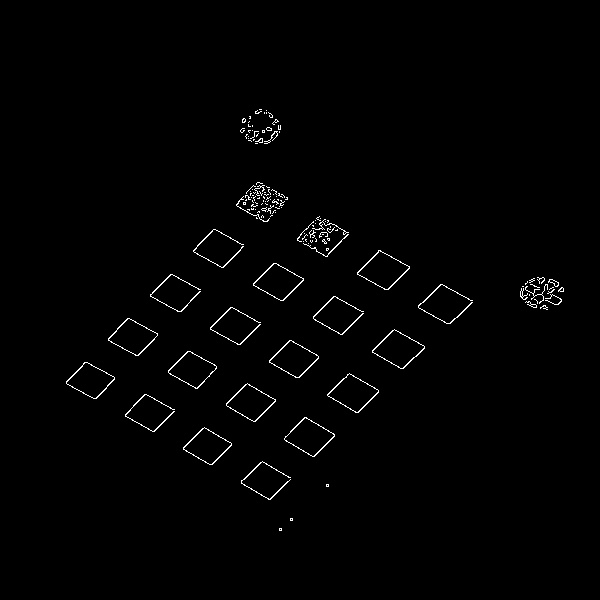

In [3]:
Image(filename='CannyEdges_own_5.jpg',width=500, height=500)

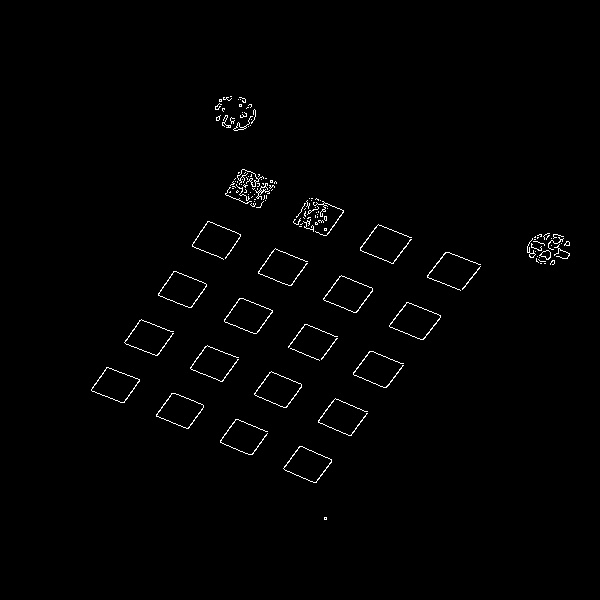

In [4]:
Image(filename='CannyEdges_own_4.jpg',width=500, height=500)

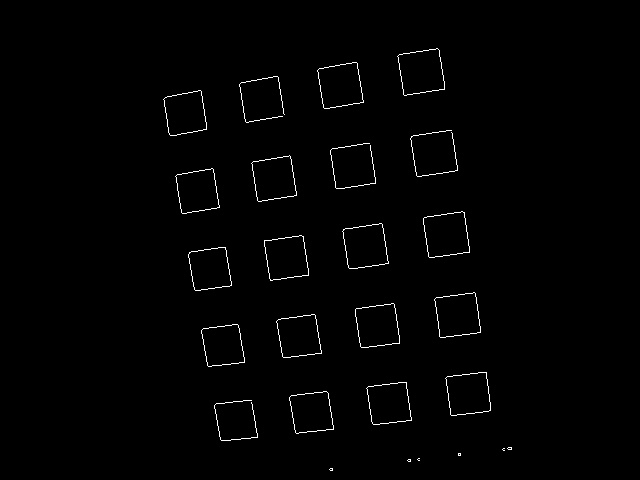

In [5]:
Image(filename='CannyEdges_Pic_31.jpg',width=500, height=500)

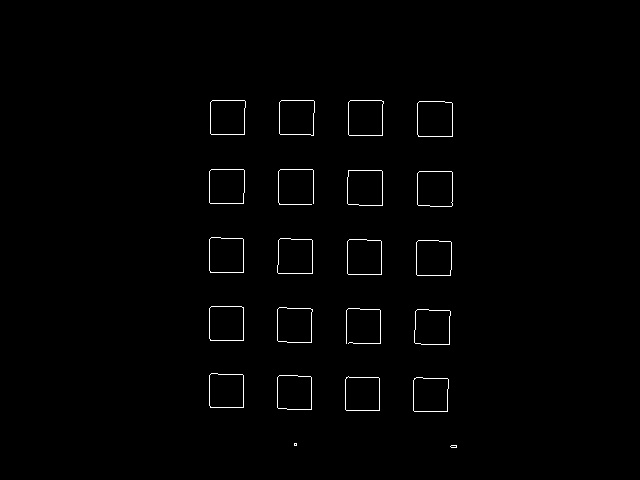

In [6]:
Image(filename='CannyEdges_Pic_11.jpg',width=500, height=500)

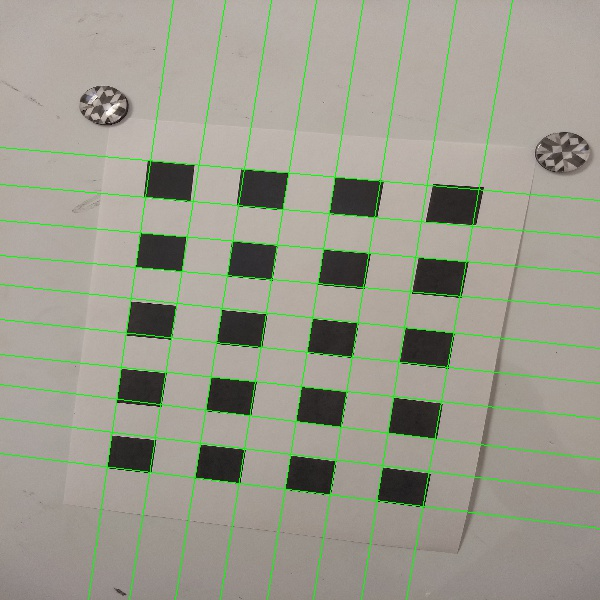

In [7]:
Image(filename='HoughTransform_own_31.jpg',width=500, height=500)

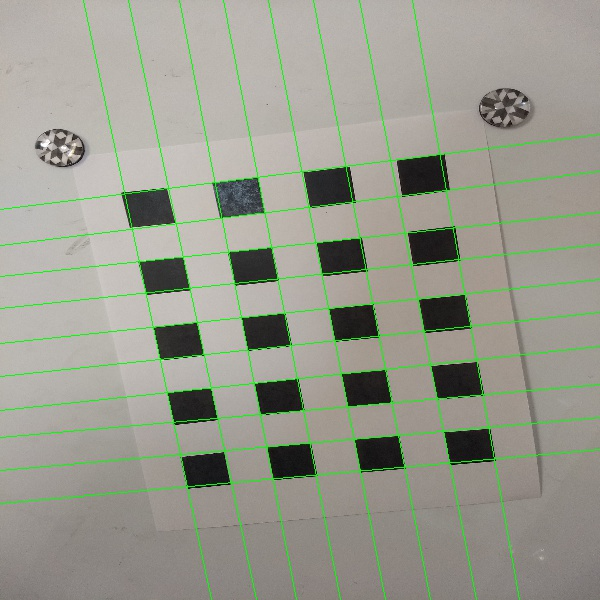

In [8]:
Image(filename='HoughTransform_own_11.jpg',width=500, height=500)

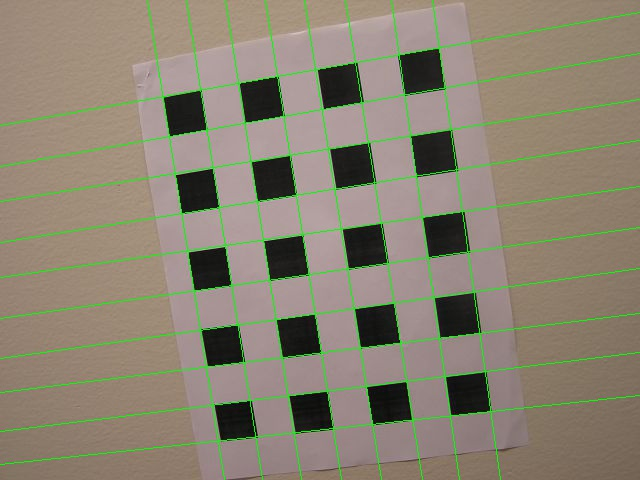

In [9]:
Image(filename='HoughTransform_Pic_31.jpg',width=500, height=500)

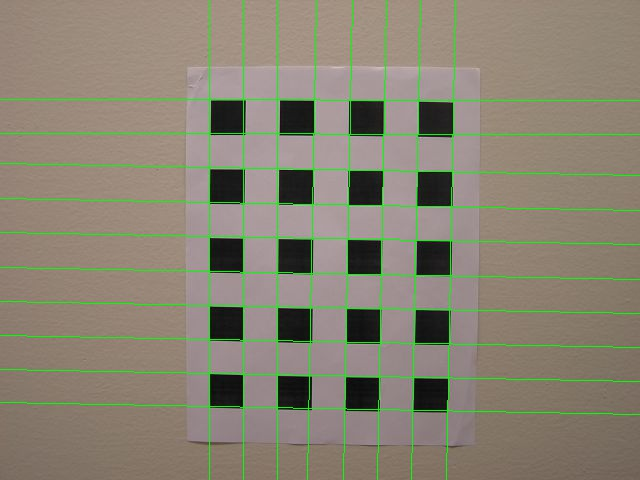

In [10]:
Image(filename='HoughTransform_Pic_11.jpg',width=500, height=500)

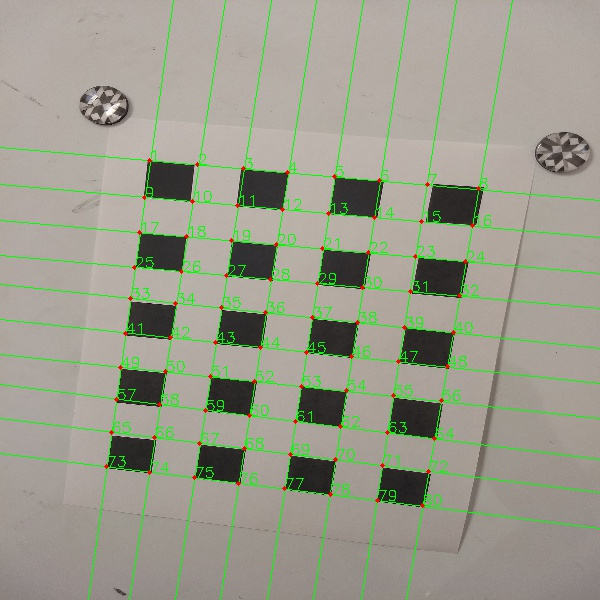

In [11]:
Image(filename='CornerLabelown_31.jpg',width=500, height=500)

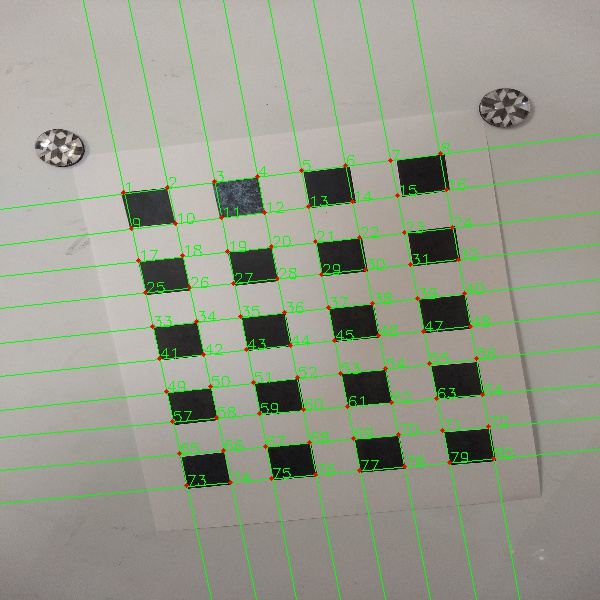

In [12]:
Image(filename='CornerLabelown_11.jpg',width=500, height=500)

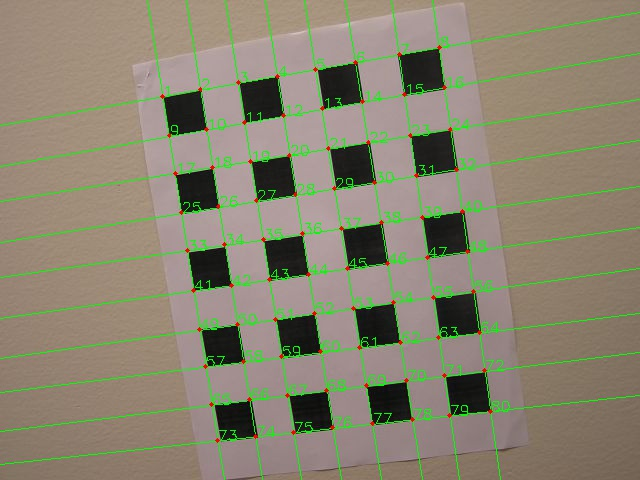

In [13]:
Image(filename='CornerLabelPic_31.jpg',width=500, height=500)

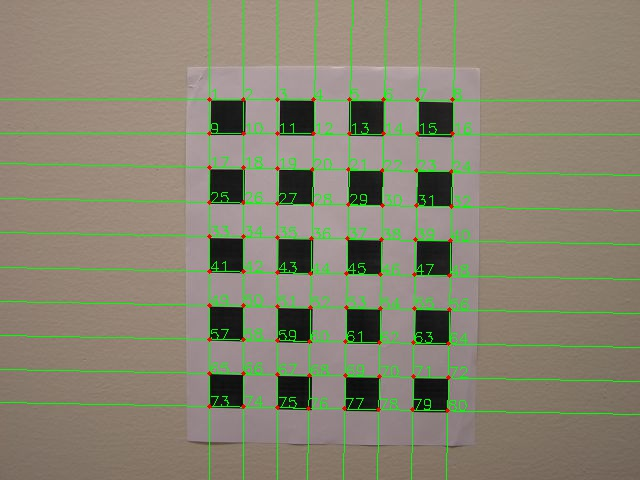

In [14]:
Image(filename='CornerLabelPic_11.jpg',width=500, height=500)

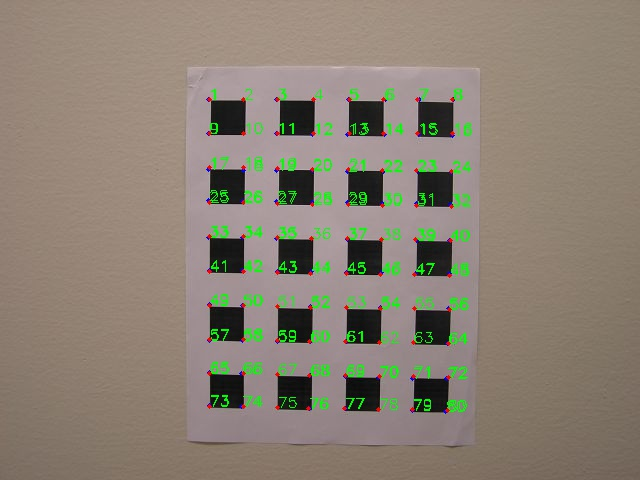

In [15]:
Image(filename='ReprojectionPic_09.jpg',width=500, height=500)

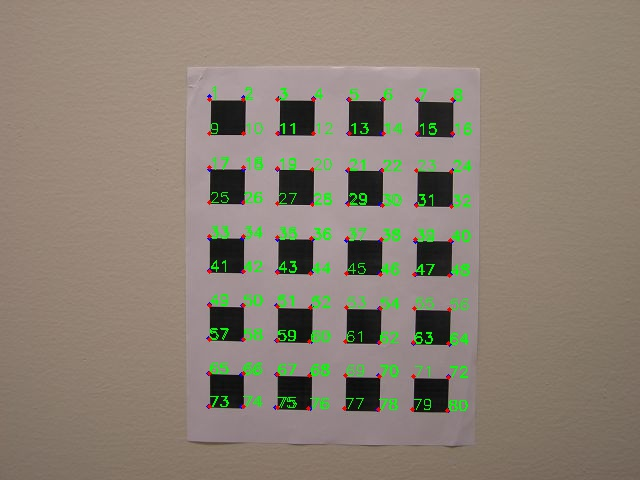

In [16]:
Image(filename='ReprojectionPic_06.jpg',width=500, height=500)

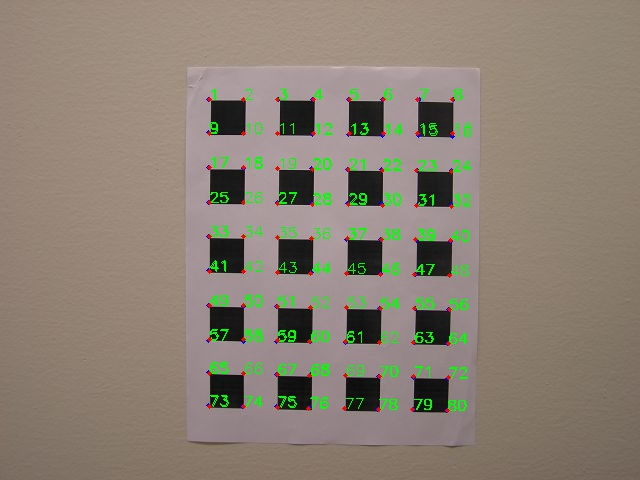

In [17]:
Image(filename='ReprojectionPic_15.jpg',width=500, height=500)

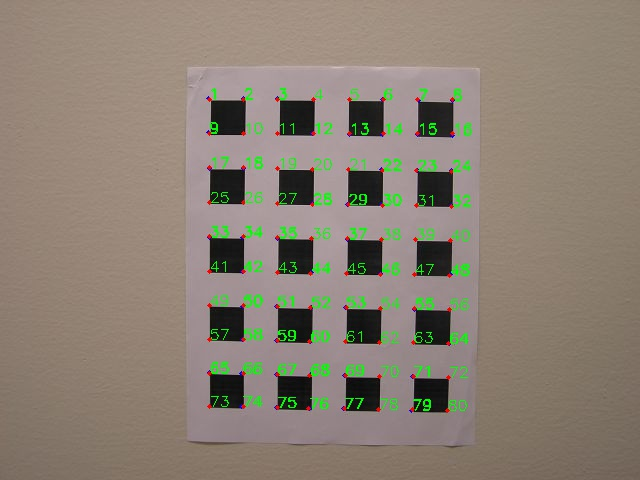

In [18]:
Image(filename='ReprojectionPic_26.jpg',width=500, height=500)

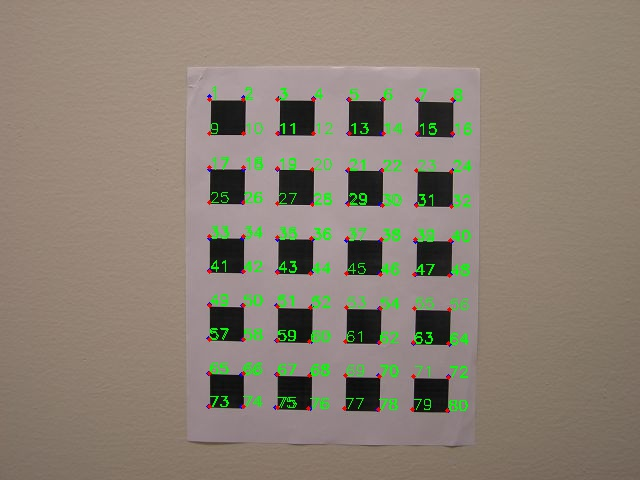

In [19]:
Image(filename='Reprojection_using_LMPic_06.jpg',width=500, height=500)

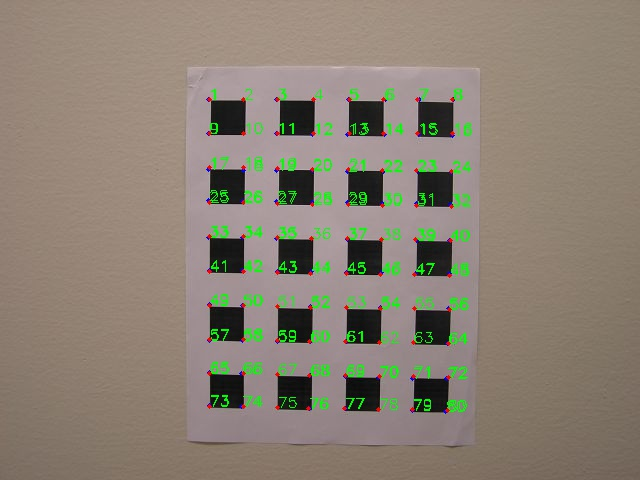

In [20]:
Image(filename='Reprojection_using_LMPic_09.jpg',width=500, height=500)

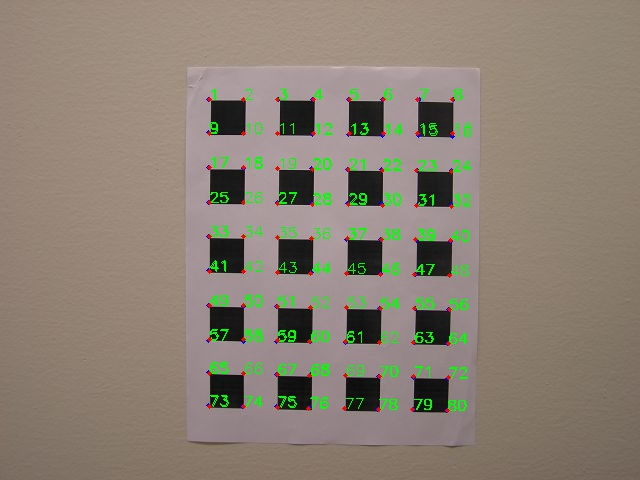

In [21]:
Image(filename='Reprojection_using_LMPic_15.jpg',width=500, height=500)

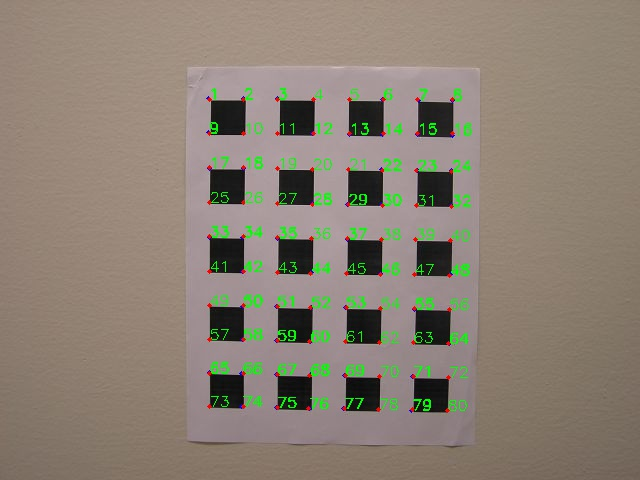

In [22]:
Image(filename='Reprojection_using_LMPic_26.jpg',width=500, height=500)

In [33]:
print("Intrinsic parameter using SVD {}".format(K))
print("Intrinsic parameter using LM {}".format(K_lm))

Intrinsic parameter using SVD [[564.53027211  -0.72077021 281.37660393]
 [  0.         424.32463862 314.87355154]
 [  0.           0.           1.        ]]
Intrinsic parameter using LM [[ 2.35732126e+04 -8.47962652e+02  4.36587050e+02]
 [ 0.00000000e+00  1.85403607e+04  1.64239899e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Extrinsic paramters are printed out individually.